In [1]:
import pandas as pd

In [2]:
news = pd.read_csv("./data/articles.csv")
print(news.shape)
news.head(3)

(27000, 2)


,doc_id,title
0,6,Заместитель председателяnправительства РФnСерг...
1,4896,Матч 1/16 финала Кубка России по футболу был п...
2,4897,Форвард «Авангарда» Томаш Заборский прокоммент...


In [3]:
users = pd.read_csv("./data/users_articles.csv")
users.head(3)

,uid,articles
0,u105138,"[293672, 293328, 293001, 293622, 293126, 1852]"
1,u108690,"[3405, 1739, 2972, 1158, 1599, 322665]"
2,u108339,"[1845, 2009, 2356, 1424, 2939, 323389]"


In [4]:
from gensim.corpora.dictionary import Dictionary

In [5]:
import re
import numpy as np
from nltk.corpus import stopwords

from razdel import tokenize

import pymorphy2  

In [6]:
import nltk 
nltk.download('stopwords')
stopword_ru = stopwords.words('russian')
len(stopword_ru)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Home\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


151

In [7]:
morph = pymorphy2.MorphAnalyzer()

In [8]:
with open('stopwords.txt') as f:
    additional_stopwords = [w.strip() for w in f.readlines() if w]
stopword_ru += additional_stopwords
len(stopword_ru)

776

In [9]:
def clean_text(text):
    '''
    очистка текста
    
    на выходе очищеный текст
    
    '''
    if not isinstance(text, str):
        text = str(text)
    
    text = text.lower()
    text = text.strip('\n').strip('\r').strip('\t')
    text = re.sub("-\s\r\n\|-\s\r\n|\r\n", '', str(text))

    text = re.sub("[0-9]|[-—.,:;_%©«»?*!@#№$^•·&()]|[+=]|[[]|[]]|[/]|", '', text)
    text = re.sub(r"\r\n\t|\n|\\s|\r\t|\\n", ' ', text)
    text = re.sub(r'[\xad]|[\s+]', ' ', text.strip())
    
    #tokens = list(tokenize(text))
    #words = [_.text for _ in tokens]
    #words = [w for w in words if w not in stopword_ru]
    
    #return " ".join(words)
    return text

cache = {}

def lemmatization(text):
    '''
    лемматизация
        [0] если зашел тип не `str` делаем его `str`
        [1] токенизация предложения через razdel
        [2] проверка есть ли в начале слова '-'
        [3] проверка токена с одного символа
        [4] проверка есть ли данное слово в кэше
        [5] лемматизация слова
        [6] проверка на стоп-слова

    на выходе лист отлемматизированых токенов
    '''

    # [0]
    if not isinstance(text, str):
        text = str(text)
    
    # [1]
    tokens = list(tokenize(text))
    words = [_.text for _ in tokens]

    words_lem = []
    for w in words:
        if w[0] == '-': # [2]
            w = w[1:]
        if len(w)>1: # [3]
            if w in cache: # [4]
                words_lem.append(cache[w])
            else: # [5]
                temp_cach = cache[w] = morph.parse(w)[0].normal_form
                words_lem.append(temp_cach)
    
    words_lem_without_stopwords=[i for i in words_lem if not i in stopword_ru] # [6]
    
    return words_lem_without_stopwords

In [10]:
%%time
#Запускаем очистку текста. Будет долго...
news['title'] = news['title'].apply(lambda x: clean_text(x), 1)

C:\Users\Home\AppData\Local\Temp/ipykernel_2620/2296537027.py:15: FutureWarning: Possible nested set at position 39
  text = re.sub("[0-9]|[-—.,:;_%©«»?*!@#№$^•·&()]|[+=]|[[]|[]]|[/]|", '', text)


Wall time: 20.6 s


In [11]:
%%time
#Запускаем лемматизацию текста. Будет очень долго...
news['title'] = news['title'].apply(lambda x: lemmatization(x), 1)

Wall time: 2min 39s


In [12]:
news['title']

0        [заместитель, председатель, правительство, рф,...
1        [матч, финал, кубок, россия, футбол, приостано...
2        [форвард, авангард, томаш, заборский, прокомме...
3        [главный, тренер, кубань, юрий, красножанин, п...
4        [решение, попечительский, совет, владивостокск...
                               ...                        
26995    [учёный, токийский, университет, морской, наук...
26996    [глава, кафедра, отечественный, история, xx, в...
26997    [американский, учёный, уточнить, возраст, расп...
26998    [последний, год, тропический, углеродный, цикл...
26999    [жить, примерно, тыс, год, назад, территория, ...
Name: title, Length: 27000, dtype: object

In [13]:
#сформируем список наших текстов, разбив еще и на пробелы
texts = [t for t in news['title'].values]

# Create a corpus from a list of texts
common_dictionary = Dictionary(texts)
common_corpus = [common_dictionary.doc2bow(text) for text in texts]

In [14]:
from gensim.models import LdaModel

In [15]:
LdaModel?

Init signature:
LdaModel(
    corpus=None,
    num_topics=100,
    id2word=None,
    distributed=False,
    chunksize=2000,
    passes=1,
    update_every=1,
    alpha='symmetric',
    eta=None,
    decay=0.5,
    offset=1.0,
    eval_every=10,
    iterations=50,
    gamma_threshold=0.001,
    minimum_probability=0.01,
    random_state=None,
    ns_conf=None,
    minimum_phi_value=0.01,
    per_word_topics=False,
    callbacks=None,
    dtype=<class 'numpy.float32'>,
)
Docstring:     
Train and use Online Latent Dirichlet Allocation model as presented in `'Online Learning for LDA' by Hoffman et al.`_

Examples
-------
Initialize a model using a Gensim corpus

.. sourcecode:: pycon

    >>> from gensim.test.utils import common_corpus
    >>>
    >>> lda = LdaModel(common_corpus, num_topics=10)

You can then infer topic distributions on new, unseen documents.

.. sourcecode:: pycon

    >>> doc_bow = [(1, 0.3), (2, 0.1), (0, 0.09)]
    >>> doc_lda = lda[doc_bow]

The model can be updated

In [16]:
%%time
from gensim.models import LdaModel
# Train the model on the corpus.
lda = LdaModel(common_corpus, num_topics=25, id2word=common_dictionary)#, passes=10)

Wall time: 48.5 s


In [17]:
from gensim.test.utils import datapath
# Save model to disk.
temp_file = datapath("model.lda")
lda.save(temp_file)

# Load a potentially pretrained model from disk.
lda = LdaModel.load(temp_file)

In [18]:
# Create a new corpus, made of previously unseen documents.
other_texts = [t for t in news['title'].iloc[:3]]
other_corpus = [common_dictionary.doc2bow(text) for text in other_texts]

unseen_doc = other_corpus[2]
print(other_texts[2])
lda[unseen_doc] 

['форвард', 'авангард', 'томаш', 'заборский', 'прокомментировать', 'игра', 'свой', 'команда', 'матч', 'чемпионат', 'кхл', 'против', 'атланта', 'nnnn', 'провести', 'плохой', 'матч', 'нижний', 'новгород', 'против', 'торпедо', 'настраиваться', 'первый', 'минута', 'включиться', 'работа', 'сказать', 'заборский', 'получиться', 'забросить', 'быстрый', 'гол', 'задать', 'хороший', 'темп', 'поединок', 'мочь', 'играть', 'ещё', 'хороший', 'сторона', 'пять', 'очко', 'выезд', 'девять', 'это', 'хороший']


[(18, 0.83177084), (20, 0.14769492)]

In [19]:
x=lda.show_topics(num_topics=25, num_words=7,formatted=False)
topics_words = [(tp[0], [wd[0] for wd in tp[1]]) for tp in x]

#Below Code Prints Only Words 
for topic,words in topics_words:
    print("topic_{}: ".format(topic)+" ".join(words))

topic_0: актёр праздновать короче герман бельгия бельгийский воробьёв
topic_1: год млн гражданин составить рост тыс рубль
topic_2: след предсказывать мексиканский nthe тон зеландия mailn
topic_3: путин млрд президент владимир россия долг российский
topic_4: экипаж содержать распоряжение освобождение норма порт ндс
topic_5: активность доклад приговор налоговый предприниматель су исследование
topic_6: операция обнаружить одежда лётчик греция грузия вскоре
topic_7: медведев место рейтинг россия польша дешёвый флот
topic_8: ракета погибнуть поверхность запуск испытание американский пилот
topic_9: год журнал станция человек стать который город
topic_10: квартира киргизия высказаться сосед владивосток таджикистан франк
topic_11: банк доллар рак налог год клиент фильм
topic_12: дело выяснить суд сотрудник человек источник который
topic_13: взрыв остров производитель лаборатория помещение индия исследование
topic_14: это который год мочь свой всё весь
topic_15: турция конкурс закон законопроек

In [20]:
def get_lda_vector(text):
    unseen_doc = common_dictionary.doc2bow(text)
    lda_tuple = lda[unseen_doc]
    not_null_topics = dict(zip([i[0] for i in lda_tuple], [i[1] for i in lda_tuple]))

    output_vector = []
    for i in range(25):
        if i not in not_null_topics:
            output_vector.append(0)
        else:
            output_vector.append(not_null_topics[i])
    return np.array(output_vector)

In [21]:
topic_matrix = pd.DataFrame([get_lda_vector(text) for text in news['title'].values])
topic_matrix.columns = ['topic_{}'.format(i) for i in range(25)]
topic_matrix['doc_id'] = news['doc_id'].values
topic_matrix = topic_matrix[['doc_id']+['topic_{}'.format(i) for i in range(25)]]
topic_matrix.head(5)

,doc_id,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_15,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24
0,6,0.0,0.0,0.0,0.026774,0.0,0.0,0.11653,0.0,0.000000,...,0.0,0.083335,0.0,0.011605,0.0,0.000000,0.013683,0.0,0.0,0.0
1,4896,0.0,0.0,0.0,0.000000,0.0,0.0,0.00000,0.0,0.163133,...,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0
2,4897,0.0,0.0,0.0,0.000000,0.0,0.0,0.00000,0.0,0.000000,...,0.0,0.000000,0.0,0.830983,0.0,0.148483,0.000000,0.0,0.0,0.0
3,4898,0.0,0.0,0.0,0.000000,0.0,0.0,0.00000,0.0,0.000000,...,0.0,0.000000,0.0,0.474537,0.0,0.069195,0.374832,0.0,0.0,0.0
4,4899,0.0,0.0,0.0,0.000000,0.0,0.0,0.00000,0.0,0.000000,...,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0


In [22]:
users.head(3)

,uid,articles
0,u105138,"[293672, 293328, 293001, 293622, 293126, 1852]"
1,u108690,"[3405, 1739, 2972, 1158, 1599, 322665]"
2,u108339,"[1845, 2009, 2356, 1424, 2939, 323389]"


In [23]:
doc_dict = dict(zip(topic_matrix['doc_id'].values, topic_matrix[['topic_{}'.format(i) for i in range(25)]].values))

In [24]:
doc_dict[293622]

array([0.03050821, 0.        , 0.        , 0.10828921, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.39010704,
       0.        , 0.        , 0.        , 0.        , 0.12493008,
       0.08448224, 0.        , 0.01605049, 0.09600303, 0.        ,
       0.03789635, 0.        , 0.        , 0.10201146, 0.        ])

In [25]:
user_articles_list = users['articles'].iloc[33]
def get_user_embedding(user_articles_list):
    user_articles_list = eval(user_articles_list)
    user_vector = np.array([doc_dict[doc_id] for doc_id in user_articles_list])
    user_vector = np.mean(user_vector, 0)
    return user_vector

In [26]:
get_user_embedding(user_articles_list)

array([0.        , 0.00865384, 0.        , 0.12392912, 0.        ,
       0.        , 0.01448929, 0.        , 0.01182432, 0.01382476,
       0.        , 0.        , 0.09075959, 0.        , 0.21672919,
       0.03558829, 0.15043364, 0.00837431, 0.0020698 , 0.        ,
       0.11161795, 0.05340025, 0.05925642, 0.08495803, 0.00183419])

In [27]:
user_embeddings = pd.DataFrame([i for i in users['articles'].apply(lambda x: get_user_embedding(x), 1)])
user_embeddings.columns = ['topic_{}'.format(i) for i in range(25)]
user_embeddings['uid'] = users['uid'].values
user_embeddings = user_embeddings[['uid']+['topic_{}'.format(i) for i in range(25)]]
user_embeddings.head(3)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_15,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24
0,u105138,0.005085,0.021843,0.006391,0.053642,0.0,0.0,0.000000,0.016668,0.002419,...,0.019371,0.153469,0.005392,0.020986,0.011574,0.112615,0.045365,0.013783,0.017002,0.020587
1,u108690,0.000000,0.019231,0.000000,0.041098,0.0,0.0,0.000000,0.000000,0.004640,...,0.003316,0.170295,0.000000,0.008189,0.000000,0.130753,0.053294,0.037533,0.043011,0.002401
2,u108339,0.000000,0.003530,0.000000,0.034673,0.0,0.0,0.053833,0.003636,0.015693,...,0.014731,0.195951,0.007014,0.016628,0.000000,0.146683,0.054469,0.090482,0.027372,0.006500


In [28]:
target = pd.read_csv("./Data/users_churn.csv")
target.head(3)

,uid,churn
0,u107120,0
1,u102277,0
2,u102444,0


In [29]:
X = pd.merge(user_embeddings, target, 'left')
X.head(3)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24,churn
0,u105138,0.005085,0.021843,0.006391,0.053642,0.0,0.0,0.000000,0.016668,0.002419,...,0.153469,0.005392,0.020986,0.011574,0.112615,0.045365,0.013783,0.017002,0.020587,0
1,u108690,0.000000,0.019231,0.000000,0.041098,0.0,0.0,0.000000,0.000000,0.004640,...,0.170295,0.000000,0.008189,0.000000,0.130753,0.053294,0.037533,0.043011,0.002401,1
2,u108339,0.000000,0.003530,0.000000,0.034673,0.0,0.0,0.053833,0.003636,0.015693,...,0.195951,0.007014,0.016628,0.000000,0.146683,0.054469,0.090482,0.027372,0.006500,1


In [30]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
#import itertools

import matplotlib.pyplot as plt

%matplotlib inline

In [31]:
X_train, X_test, y_train, y_test = train_test_split(X[['topic_{}'.format(i) for i in range(25)]], 
                                                    X['churn'], random_state=0)

In [32]:
logreg = LogisticRegression()
#обучим 
logreg.fit(X_train, y_train)

LogisticRegression()

In [33]:
#наши прогнозы для тестовой выборки
preds = logreg.predict_proba(X_test)[:, 1]
preds[:10]

array([0.28871802, 0.01241313, 0.29608426, 0.2284118 , 0.03420164,
       0.08561039, 0.16153113, 0.05105529, 0.02239288, 0.13426037])

In [34]:
from sklearn.metrics import f1_score, roc_auc_score, precision_score, classification_report, precision_recall_curve, confusion_matrix

In [35]:
import itertools

In [36]:
precision, recall, thresholds = precision_recall_curve(y_test, preds)
fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], 
                                                                        fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix]))
precision_mean = precision[ix]
recall_mean = recall[ix]
thresholds_mean = thresholds[ix]
fscore_mean = fscore[ix]

Best Threshold=0.259463, F-Score=0.648, Precision=0.559, Recall=0.771


In [37]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[1606  149]
 [  57  188]]


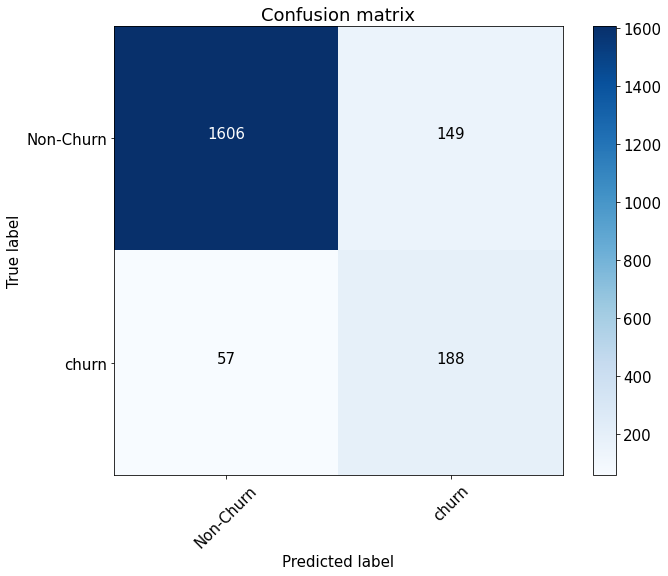

In [38]:
#мы уже нашли ранее "оптимальный" порог, когда максимизировали f_score
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_test, preds>thresholds[ix])
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['Non-Churn', 'churn'],
                      title='Confusion matrix')
plt.savefig("conf_matrix.png")
plt.show()

In [39]:
ras_mean = roc_auc_score(y_test, preds)

2. Модифицировать код функции get_user_embedding таким образом, чтобы считалось не среднее (как в примере np.mean), а медиана. Применить такое преобразование к данным, обучить модель прогнозирования оттока и посчитать метрики качества и сохранить их: roc auc, precision/recall/f_score (для 3 последних - подобрать оптимальный порог с помощью precision_recall_curve, как это делалось на уроке)

In [40]:
def get_user_embedding_med(user_articles_list):
    user_articles_list = eval(user_articles_list)
    user_vector = np.array([doc_dict[doc_id] for doc_id in user_articles_list])
    user_vector = np.median(user_vector, 0)
    return user_vector

In [41]:
get_user_embedding_med(user_articles_list)

user_embeddings = pd.DataFrame([i for i in users['articles'].apply(lambda x: get_user_embedding_med(x), 1)])
user_embeddings.columns = ['topic_{}'.format(i) for i in range(25)]
user_embeddings['uid'] = users['uid'].values
user_embeddings = user_embeddings[['uid']+['topic_{}'.format(i) for i in range(25)]]

X = pd.merge(user_embeddings, target, 'left')

X_train, X_test, y_train, y_test = train_test_split(X[['topic_{}'.format(i) for i in range(25)]], 
                                                    X['churn'], random_state=0)

logreg = LogisticRegression()
logreg.fit(X_train, y_train)

preds = logreg.predict_proba(X_test)[:, 1]

precision, recall, thresholds = precision_recall_curve(y_test, preds)
def return_metrics(precision, recall, thresholds):
    fscore = (2 * precision * recall) / (precision + recall)
    ix = np.argmax(fscore) 
    return precision[ix], recall[ix], thresholds[ix], fscore[ix]

precision_median, recall_median, thresholds_median, fscore_median = return_metrics(precision, recall, thresholds)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds_median, 
                                                                        fscore_median,
                                                                        precision_median,
                                                                        recall_median))

Best Threshold=0.326327, F-Score=0.727, Precision=0.715, Recall=0.739


Confusion matrix, without normalization
[[1507  248]
 [  19  226]]


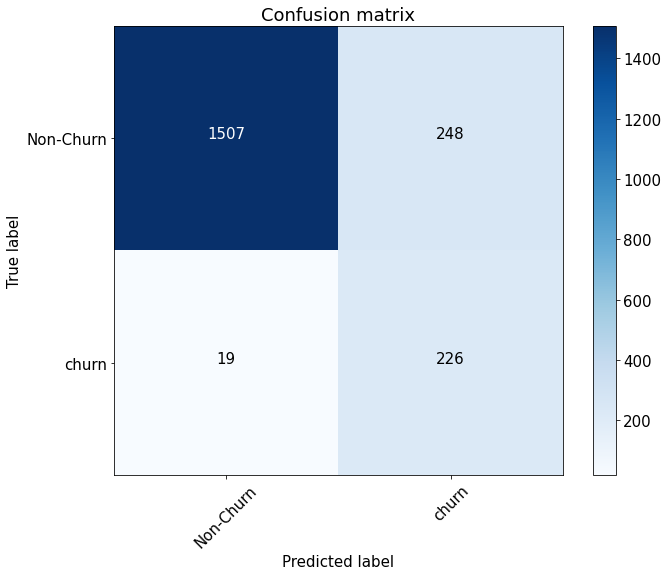

In [42]:
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_test, preds>thresholds[ix])
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['Non-Churn', 'churn'],
                      title='Confusion matrix')
plt.savefig("conf_matrix.png")
plt.show()

In [43]:
ras_median = roc_auc_score(y_test, preds)

3. Повторить п.2, но используя уже не медиану, а max

In [44]:
def get_user_embedding_max(user_articles_list):
    user_articles_list = eval(user_articles_list)
    user_vector = np.array([doc_dict[doc_id] for doc_id in user_articles_list])
    user_vector = np.max(user_vector, 0)
    return user_vector

In [45]:
get_user_embedding_max(user_articles_list)

user_embeddings = pd.DataFrame([i for i in users['articles'].apply(lambda x: get_user_embedding_max(x), 1)])
user_embeddings.columns = ['topic_{}'.format(i) for i in range(25)]
user_embeddings['uid'] = users['uid'].values
user_embeddings = user_embeddings[['uid']+['topic_{}'.format(i) for i in range(25)]]

X = pd.merge(user_embeddings, target, 'left')

X_train, X_test, y_train, y_test = train_test_split(X[['topic_{}'.format(i) for i in range(25)]], 
                                                    X['churn'], random_state=0)

logreg = LogisticRegression()
logreg.fit(X_train, y_train)

preds = logreg.predict_proba(X_test)[:, 1]

precision, recall, thresholds = precision_recall_curve(y_test, preds)
def return_metrics(precision, recall, thresholds):
    fscore = (2 * precision * recall) / (precision + recall)
    ix = np.argmax(fscore) 
    return precision[ix], recall[ix], thresholds[ix], fscore[ix]

precision_max, recall_max, thresholds_max, fscore_max = return_metrics(precision, recall, thresholds)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds_median, 
                                                                        fscore_median,
                                                                        precision_median,
                                                                        recall_median))

Best Threshold=0.326327, F-Score=0.727, Precision=0.715, Recall=0.739


Confusion matrix, without normalization
[[1264  491]
 [   6  239]]


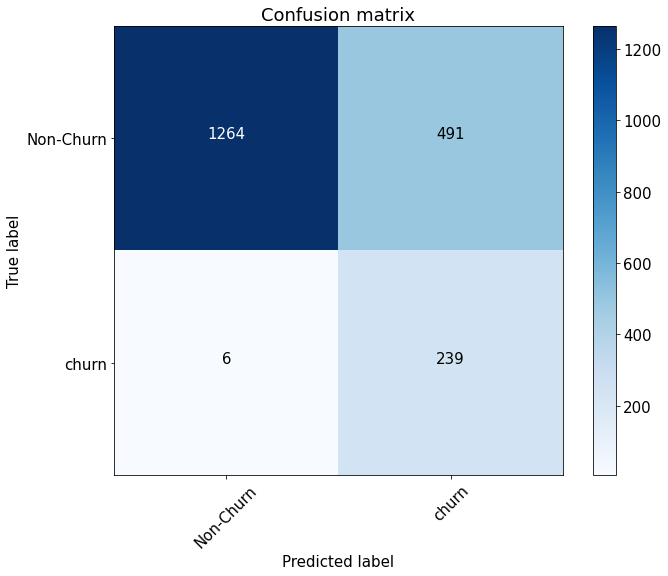

In [46]:
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_test, preds>thresholds[ix])
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['Non-Churn', 'churn'],
                      title='Confusion matrix')
plt.savefig("conf_matrix.png")
plt.show()

In [47]:
ras_max = roc_auc_score(y_test, preds)

4. (опциональное, если очень хочется) Воспользовавшись полученными знаниями из п.1, повторить пункт 2, но уже взвешивая новости по tfidf (подсказка: нужно получить веса-коэффициенты для каждого документа. Не все документы одинаково информативны и несут какой-то положительный сигнал). Подсказка 2 - нужен именно idf, как вес.

5. Сформировать на выходе единую таблицу, сравнивающую качество 3 разных метода получения эмбедингов пользователей: mean, median, max, idf_mean по метрикам roc_auc, precision, recall, f_score

In [48]:
table_data = [['mean', ras_mean, precision_mean, recall_mean, fscore_mean], 
              ['median', ras_median, precision_median, recall_median, fscore_median],
              ['max', ras_max, precision_max, recall_max, fscore_max]]
table_df = pd.DataFrame(table_data, columns=['model', 'roc_auc', 'precision', 'recall', 'f_score'])
table_df

,model,roc_auc,precision,recall,f_score
0,mean,0.942036,0.559172,0.771429,0.648370
1,median,0.960854,0.715415,0.738776,0.726908
2,max,0.966531,0.788136,0.759184,0.773389


6. Сделать самостоятельные выводы и предположения о том, почему тот или ной способ оказался эффективнее остальных

Похоже, лучше всего себя зарекомендовал себя функция max, так как максимальное предположение лучше характеризует пользователя.